In [1]:
import numpy as np
import MDAnalysis as md
import matplotlib.pyplot as plt
from shapeGMMTorch import torch_sgmm
%matplotlib inline

In [2]:
from MDAnalysis.analysis.distances import self_distance_array

# based on up to max_pair interaction
def compute_enm_energy(ref_structure, ks, rmins, max_pair):
    n_atoms = ref_structure.shape[0]
    energy = 0.0
    # calculate pair interactions
    for atom1 in range(n_atoms-1):
        max_atom2 = min(n_atoms,atom1+max_pair)
        for atom2 in range(atom1+2,max_atom2):
            bi = atom2-atom1-1
            sep = ref_structure[atom2] - ref_structure[atom1]
            dist = np.linalg.norm(sep)
            energy += ks[bi]*(dist-rmins[bi])**2   # no 1/2 to be consistent with LAMMPS
            bi += 1
    return energy

# based on up to max_pair interaction
def compute_enm_energy_all_pairs(ref_structure, ks, rmins):
    n_atoms = ref_structure.shape[0]
    energy = 0.0
    # calculate pair interactions
    bi = 0
    for atom1 in range(n_atoms-1):
        for atom2 in range(atom1+1,n_atoms):
            sep = ref_structure[atom2] - ref_structure[atom1]
            dist = np.linalg.norm(sep)
            energy += ks[bi]*(dist-rmins[bi])**2   # no 1/2 to be consistent with LAMMPS
            bi += 1
    return energy

def lj_e(r,sigma,eps):
    sigma_over_r_6 = (sigma/r)**6
    return 4*eps*sigma_over_r_6*(sigma_over_r_6-1)

# based on up to max_pair interaction
def compute_lj_energy(ref_structure, eps):
    n_atoms = ref_structure.shape[0]
    energy = 0.0
    nearest_neighbor_k = 100.0
    nearest_neighbor_r0 = 1.0
    alpha_1_5_eps = eps
    alpha_1_5_sigma = 1.5
    alpha_1_5_cut = 2*alpha_1_5_sigma
    alpha_1_5_shift = lj_e(alpha_1_5_cut,alpha_1_5_sigma,alpha_1_5_eps)
    all_other_eps = 3.0
    all_other_sigma = 1.5
    all_other_cut = all_other_sigma*1.12246204831
    all_other_shift = lj_e(all_other_cut,all_other_sigma,all_other_eps)
    # calculate pair interactions
    for atom1 in range(n_atoms-1):
        for atom2 in range(atom1+1,n_atoms):
            bi = atom2-atom1-1
            sep = ref_structure[atom2] - ref_structure[atom1]
            dist = np.linalg.norm(sep)
            # 1-2 bonded interactions
            if bi==0:
                energy += nearest_neighbor_k*(dist-nearest_neighbor_r0)**2
            # 1-3 interactions are all other LJ but scaled by 0.5
            elif bi==1:
                if dist < all_other_cut:
                    energy += 0.5*(lj_e(dist,all_other_sigma,all_other_eps)-all_other_shift)
            # 1-5 interactions are the strong alpha helix interactions
            elif bi==3:
                if dist < alpha_1_5_cut:
                    energy += lj_e(dist,alpha_1_5_sigma,alpha_1_5_eps)-alpha_1_5_shift
                if dist < all_other_cut:
                    energy += lj_e(dist,all_other_sigma,all_other_eps)-all_other_shift
            # every other interaction which just includes repulsive part of LJ
            else:
                if dist < all_other_cut:
                    energy += lj_e(dist,all_other_sigma,all_other_eps)-all_other_shift
    return energy

In [3]:
pdb = '../helix_template.pdb'
dcd = '../run_files/helix_folding_eps6.0.dcd'
traj = md.Universe(pdb,dcd)
print(traj.trajectory.n_frames)
lj_energies_eps6 = []
lj_energies_eps18 = []
lj_energies_eps30 = []
lj_energies_eps60 = []
sel = traj.select_atoms("all")
for ts in traj.trajectory:
    lj_energies_eps6.append(compute_lj_energy(sel.positions,6.0))
    lj_energies_eps18.append(compute_lj_energy(sel.positions,18.0))
    lj_energies_eps30.append(compute_lj_energy(sel.positions,30.0))
    lj_energies_eps60.append(compute_lj_energy(sel.positions,60.0))
lj_energies_eps6 = np.array(lj_energies_eps6)
lj_energies_eps18 = np.array(lj_energies_eps18)
lj_energies_eps30 = np.array(lj_energies_eps30)
lj_energies_eps60 = np.array(lj_energies_eps60)
np.savetxt("lj_energies_eps6.dat",lj_energies_eps6)
np.savetxt("lj_energies_eps18.dat",lj_energies_eps18)
np.savetxt("lj_energies_eps30.dat",lj_energies_eps30)
np.savetxt("lj_energies_eps60.dat",lj_energies_eps60)

100001


In [2]:
pdb = '../helix_template.pdb'
dcd = '../run_files/helix_folding_eps6.0.dcd'
traj = md.Universe(pdb,dcd)
print(traj.trajectory.n_frames)
sel = traj.select_atoms("all")

100001


In [6]:
#read lj energies
lj_energies_eps6 = np.loadtxt("lj_energies_eps6.dat")

In [4]:
eps_range = np.array([4.5, 4.6, 4.7, 4.8, 4.9])
lj_energies = np.empty(traj.trajectory.n_frames)
for eps in eps_range:
    for ts in traj.trajectory:
        lj_energies[ts.frame] = compute_lj_energy(sel.positions,eps)
    lj_energies -= np.amin(lj_energies)
    weights = np.exp(-(lj_energies-lj_energies_eps6)/1.0)
    weights /= np.sum(weights)
    file_name = "eps" + str(eps) + "_frame_weights.dat"
    np.savetxt(file_name,weights)

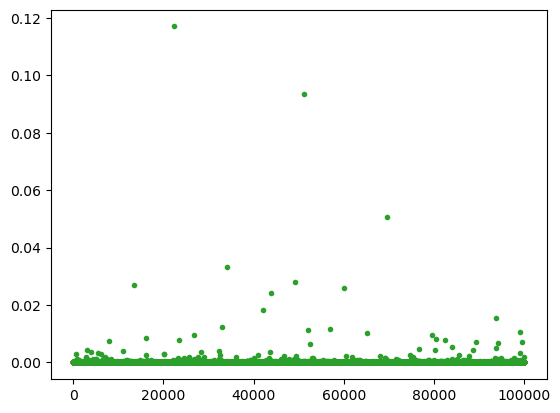

In [17]:
file_name = "eps" + str(3) + "_frame_weights.dat"
weights = np.loadtxt(file_name)
for cluster_id in range(wsgmm.n_clusters):
    indeces = np.argwhere(wsgmm.cluster_ids==cluster_id).flatten()
    plt.plot(indeces,weights[indeces],'.')

In [29]:
#read lj energies
lj_energies_eps6 = np.loadtxt("lj_energies_eps6.dat")
lj_energies_eps18 = np.loadtxt("lj_energies_eps18.dat")
lj_energies_eps30 = np.loadtxt("lj_energies_eps30.dat")
lj_energies_eps60 = np.loadtxt("lj_energies_eps60.dat")

In [51]:
print(-2.873048+0.35796656)
print(-2.7620654+0.38113874)
print(-2.939213+0.45699338)
print(-2.8400978+0.31664664)
print(-2.5794451+0.39706989)

-2.51508144
-2.38092666
-2.48221962
-2.52345116
-2.18237521


In [7]:
print(lj_energies_eps6/12)

[-2.5150818  -2.38092618 -2.47740012 ... -2.69589872 -2.52324048
 -2.18237515]


In [30]:
lj_energies_eps6 -= np.amin(lj_energies_eps6)
lj_energies_eps18 -= np.amin(lj_energies_eps18)
lj_energies_eps30 -= np.amin(lj_energies_eps30)
lj_energies_eps60 -= np.amin(lj_energies_eps60)

In [9]:
# load pickled object
import pickle
file_obj = open("../sgmm3.obj","rb")
wsgmm = pickle.load(file_obj)
file_obj.close()
cluster_ids = wsgmm.cluster_ids

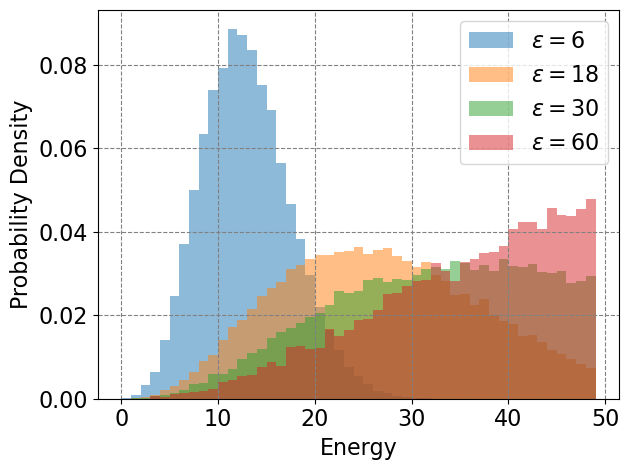

In [31]:
colors = ["tab:red", "tab:blue", "tab:green"]
for cluster_id in range(wsgmm.n_clusters-2):
    indeces = np.argwhere(wsgmm.cluster_ids==cluster_id).flatten()
    plt.hist(lj_energies_eps6[indeces],bins=np.arange(0,50,1.0),alpha=0.5,density=True,label="$\epsilon=6$")
    plt.hist(lj_energies_eps18[indeces],bins=np.arange(0,50,1.0),alpha=0.5,density=True,label="$\epsilon=18$")
    plt.hist(lj_energies_eps30[indeces],bins=np.arange(0,50,1.0),alpha=0.5,density=True,label="$\epsilon=30$")
    plt.hist(lj_energies_eps60[indeces],bins=np.arange(0,50,1.0),alpha=0.5,density=True,label="$\epsilon=60$")
plt.grid(which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("Probability Density",size=16)
plt.xlabel("Energy",size=16)
plt.tick_params(axis='both',labelsize=16)
plt.legend(fontsize=16)
plt.tight_layout();

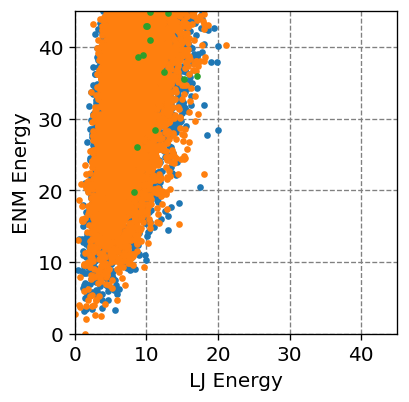

In [14]:
fig, ax = plt.subplots(1,1,dpi=120,figsize=(3.5,3.5))
for cluster_id in range(wsgmm.n_clusters):
    indeces = np.argwhere(wsgmm.cluster_ids==cluster_id).flatten()
    ax.plot(lj_energies_eps6[indeces],lj_energies_eps60[indeces],'.')
plt.grid(which='major', axis='both', color='#808080', linestyle='--')
plt.ylabel("ENM Energy",size=12)
plt.xlabel("LJ Energy",size=12)
plt.tick_params(axis='both',labelsize=12)
#plt.legend(fontsize=16)
ax.set_aspect('equal', adjustable='box')
plt.xlim(0,45)
plt.ylim(0,45)
plt.tight_layout();

In [18]:
weights = np.exp(-(lj_energies_eps60-lj_energies_eps6)/1.0)
weights /= np.sum(weights)
#np.savetxt('symmetrized_enm_rmean_frame_weights_kT_1.dat',weights_rmean)

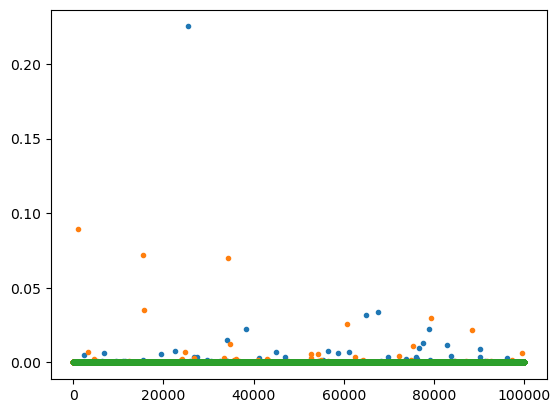

In [19]:
for cluster_id in range(wsgmm.n_clusters):
    indeces = np.argwhere(wsgmm.cluster_ids==cluster_id).flatten()
    plt.plot(indeces,weights[indeces],'.')

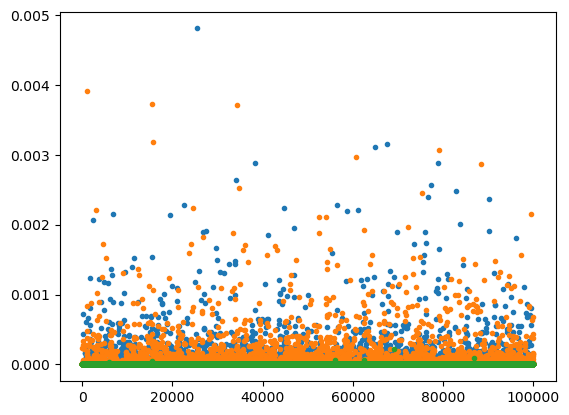

In [24]:
weights = np.exp(-(lj_energies_eps18-lj_energies_eps6)/1.0)
weights /= np.sum(weights)
for cluster_id in range(wsgmm.n_clusters):
    indeces = np.argwhere(wsgmm.cluster_ids==cluster_id).flatten()
    plt.plot(indeces,weights[indeces],'.')
np.savetxt("weights_eps18.dat",weights)

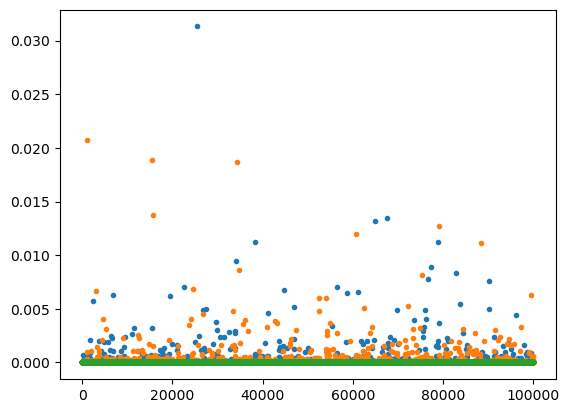

In [23]:
weights = np.exp(-(lj_energies_eps30-lj_energies_eps6)/1.0)
weights /= np.sum(weights)
for cluster_id in range(wsgmm.n_clusters):
    indeces = np.argwhere(wsgmm.cluster_ids==cluster_id).flatten()
    plt.plot(indeces,weights[indeces],'.')
np.savetxt("weights_eps30.dat",weights)